Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 256)         2

2152/2152 [==============================] - 301s 140ms/step - loss: 1.2268 - accuracy: 0.7730 - val_loss: 1.5306 - val_accuracy: 0.7805 - lr: 1.0000e-07
Epoch 2/50
2152/2152 [==============================] - 298s 139ms/step - loss: 1.2135 - accuracy: 0.7725 - val_loss: 1.4859 - val_accuracy: 0.7811 - lr: 1.0000e-07
Epoch 3/50
2152/2152 [==============================] - 298s 139ms/step - loss: 1.2132 - accuracy: 0.7752 - val_loss: 1.4573 - val_accuracy: 0.7820 - lr: 1.0000e-07
Epoch 4/50
2152/2152 [==============================] - 299s 139ms/step - loss: 1.2136 - accuracy: 0.7752 - val_loss: 1.4830 - val_accuracy: 0.7844 - lr: 1.0000e-07
Epoch 5/50
2152/2152 [==============================] - 301s 140ms/step - loss: 1.2067 - accuracy: 0.7752 - val_loss: 1.4867 - val_accuracy: 0.7859 - lr: 5.0000e-07
Epoch 6/50
2152/2152 [==============================] - 302s 140ms/step - loss: 1.1926 - accuracy: 0.7778 - val_loss: 1.5869 - val_accuracy: 0.7887 - lr: 9.0000e-07
Epoch 7/50
2152/2152 

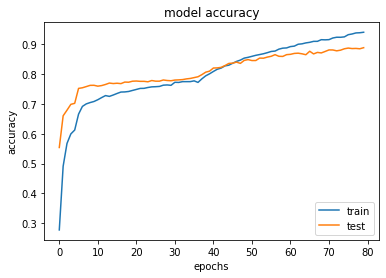

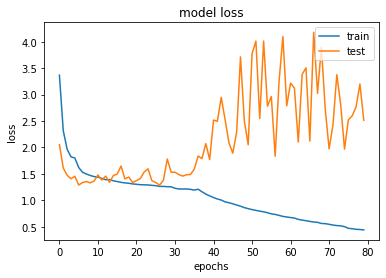

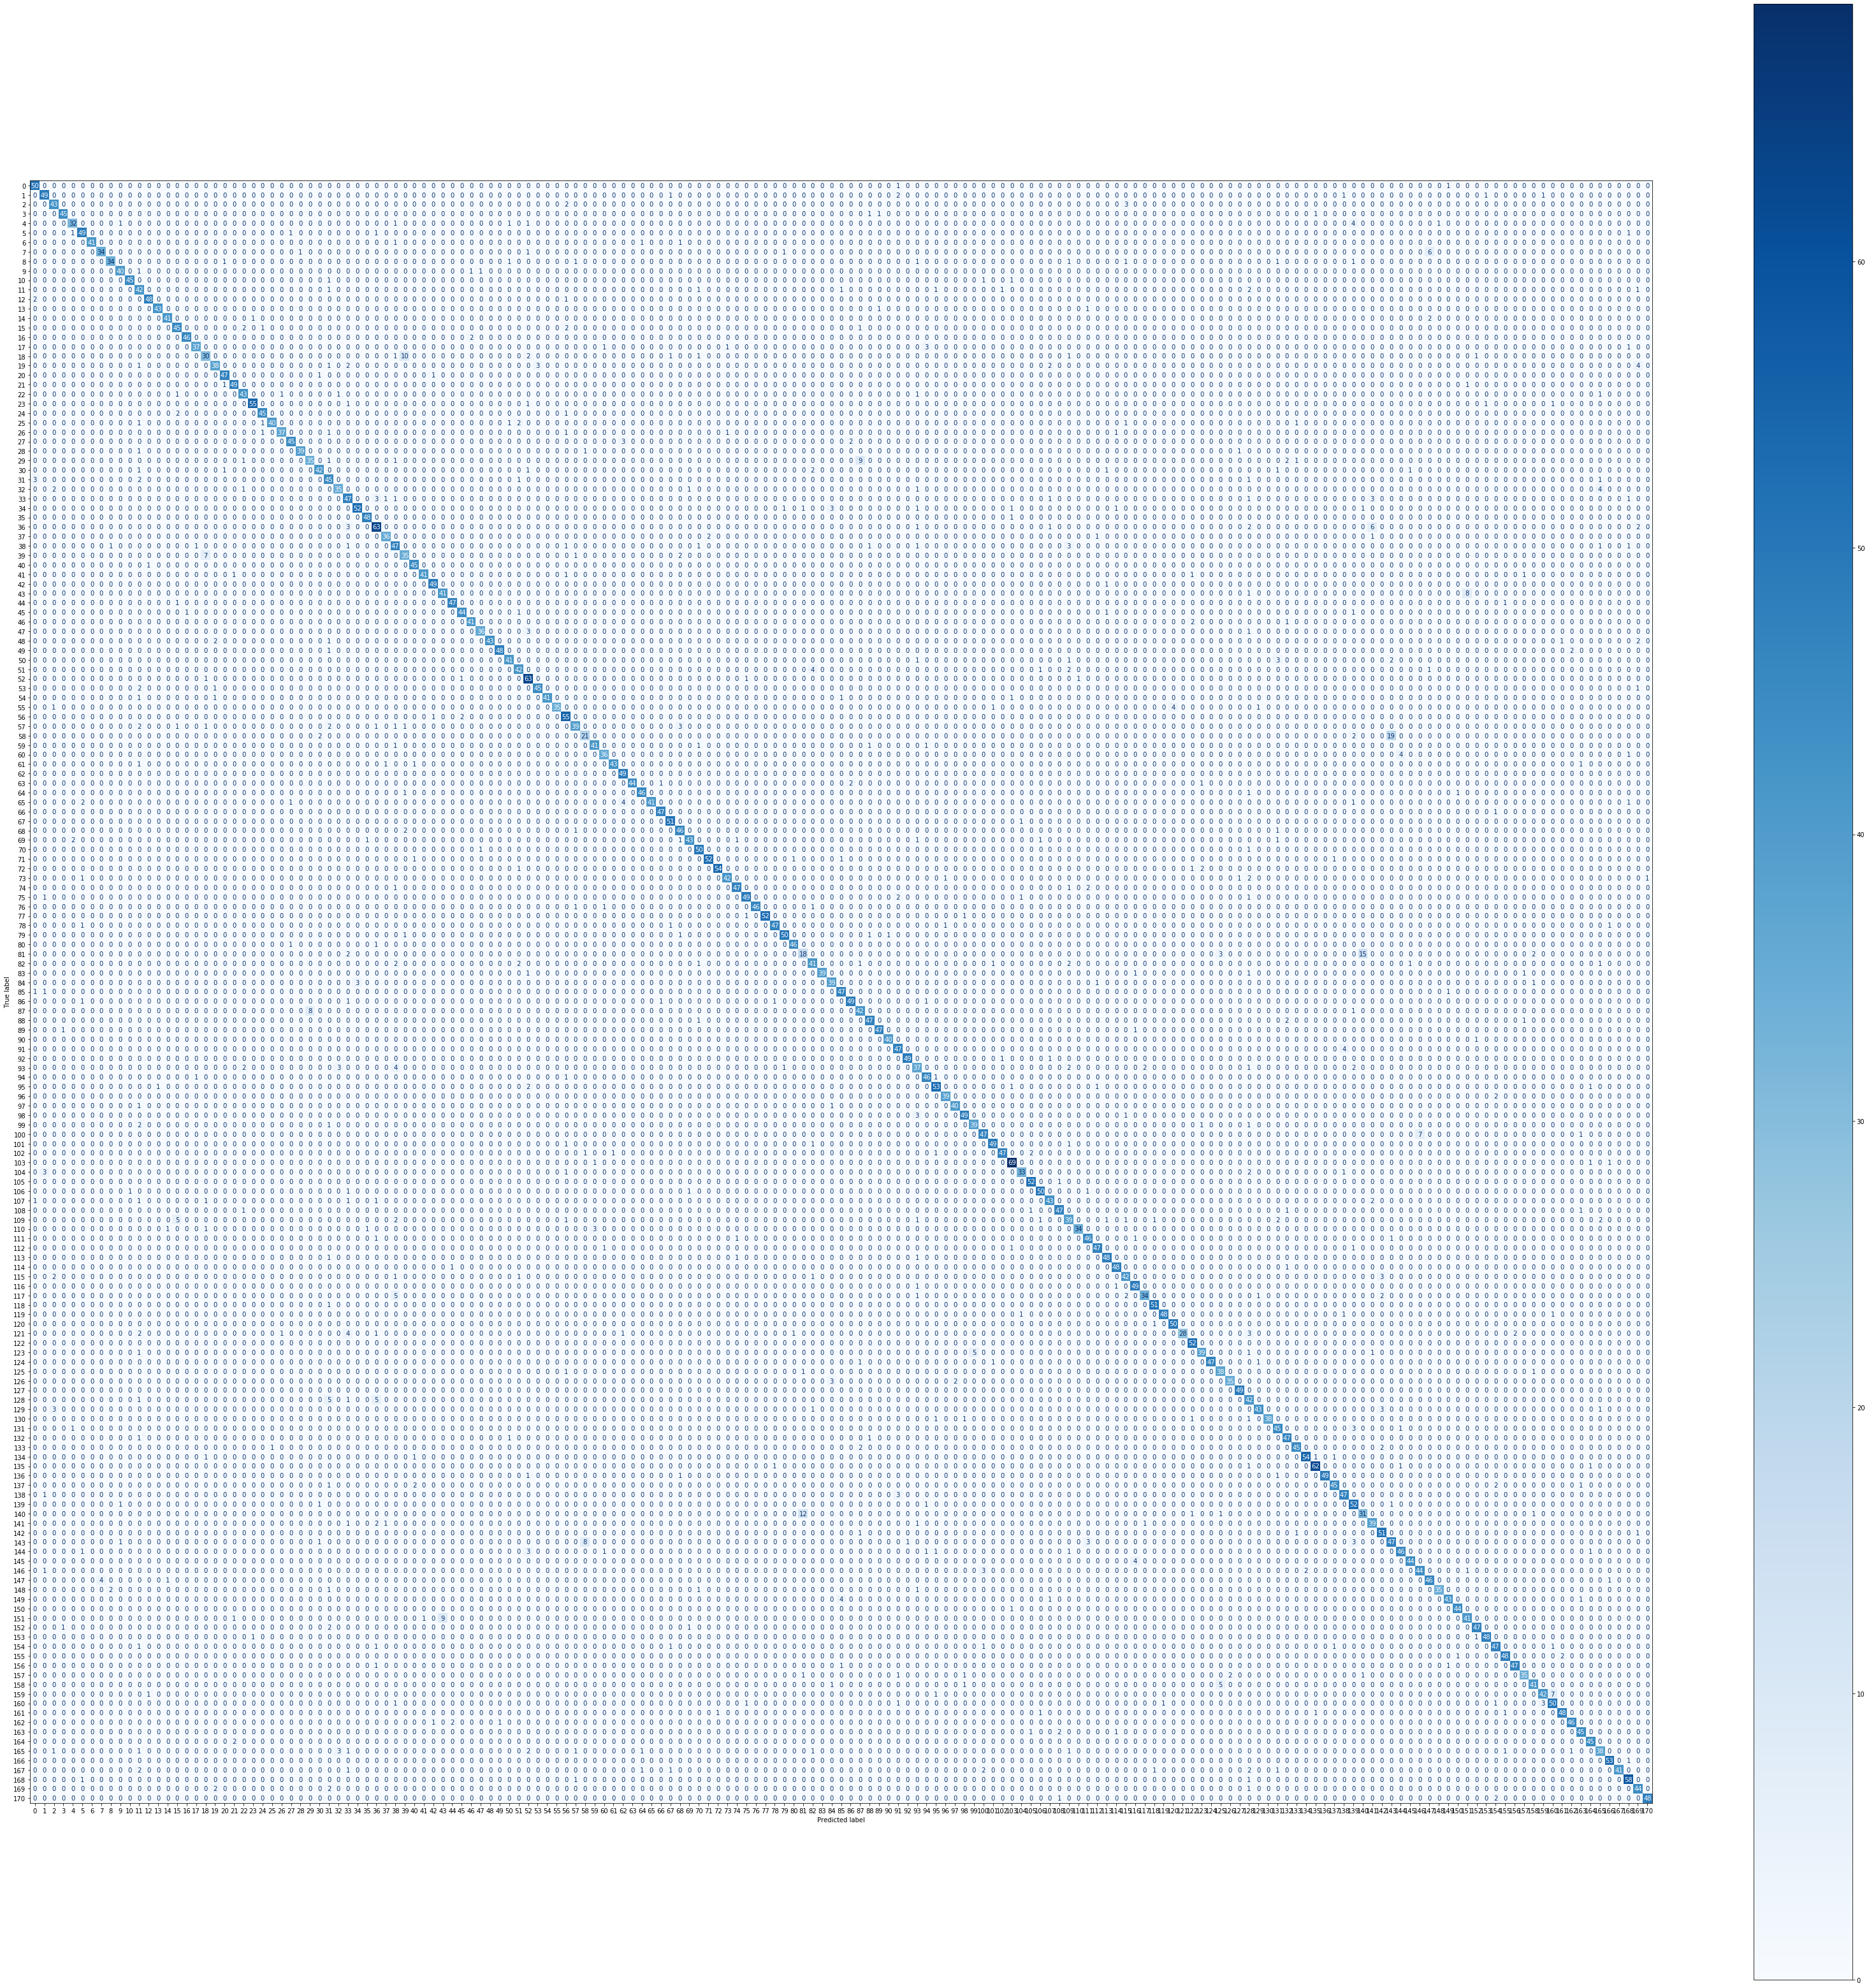

In [1]:
# with fine tuning
import os
import numpy as np
import matplotlib.pyplot as plt
import glob

%matplotlib inline

# example of horizontal shift image augmentation
from numpy import expand_dims
from tensorflow import keras
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras.models import Model

from keras.optimizers import RMSprop
from keras.optimizers import Adam

# pre-trained models
from tensorflow.keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3

from keras.layers import BatchNormalization as BatchNorm
import tensorflow as tf
import math

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

import learning_rate2 as lr

np.random.seed(1)
tf.random.set_seed(1)

# dataset details
train_data_dir = './Data/Offline/CMATERdb3.1.3.3/Train/'
validation_data_dir = './Data/Offline/CMATERdb3.1.3.3/Test/'
nb_train_samples = 34439
nb_validation_samples = 8520
num_classes = 171

epochs1 = 30
epochs2 = 50
batch_size = 16
# dimensions of our images.
img_width, img_height = 32, 32
input_shape = (img_width, img_height, 3)

# using VGG16
# load model without classifier layers
model = Sequential()
# # create the VGG16 model with only the convolutional layers, and using weights from ImageNet
source_model = VGG16(include_top=False, input_shape=input_shape)

# mark loaded layers as not trainable
for layer in source_model.layers[:-6]:
    layer.trainable = False
    model.add(layer)

model.add(BatchNorm())
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNorm())
model.add(Dropout(0.35))
model.add(Dense(512, activation='relu'))
model.add(BatchNorm())
model.add(Dropout(0.35))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(), metrics=['accuracy'])
print(model.summary())

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
                    rescale=1.0/255,
                #     rotation_range=5,
                #     shear_range=0.1,
                #     validation_split=0.2,
                #     zoom_range=0.05,
                # #     fill_mode='nearest'
                #     horizontal_flip=False
                )

# this is the augmentation configuration we will use for testing:
# only rescaling for test dataset
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode="rgb",
    class_mode='categorical',
#     subset='training',
    shuffle=True,
    seed=13)

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=nb_validation_samples,
    color_mode="rgb",
#     subset='validation',
    shuffle=False,
    class_mode='categorical')

# custom learning rate
callback = tf.keras.callbacks.LearningRateScheduler(lr.decayed_learning_rate)

history1 = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs1,
    callbacks=[callback],
    validation_data=validation_generator,
    validation_steps=1)


# fine tuning the model
# mark layers as trainable
for layer in model.layers[:12]:
    layer.trainable = True

train_generator.reset()
validation_generator.reset()

model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(), metrics=['accuracy'])
print(model.summary())

# custom learning rate
callback = tf.keras.callbacks.LearningRateScheduler(lr.decayed_learning_rate_tuned_complex)

history2 = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs2,
    callbacks=[callback],
    validation_data=validation_generator,
    validation_steps=1)

# model.save_weights('first_try0.h5')

# summarize history for accuracy
plt.plot(history1.history['accuracy']+history2.history['accuracy'])
plt.plot(history1.history['val_accuracy']+history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(history1.history['loss']+history2.history['loss'])
plt.plot(history1.history['val_loss']+history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

filenames = validation_generator.filenames

predict = model.predict(validation_generator)
y_pred = np.argmax(predict,axis=-1)

cm = confusion_matrix(validation_generator.classes,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm,
#                               display_labels=clf.classes_)

fig, ax = plt.subplots(figsize=(math.ceil(num_classes/3.0), math.ceil(num_classes/3.0)))
disp.plot(ax=ax, cmap=plt.cm.Blues)

In [2]:
print('precision_score: ', precision_score(validation_generator.classes,y_pred, average="macro"))
print('recall_score   : ', recall_score(validation_generator.classes,y_pred, average="macro"))
print('f1_score       : ', f1_score(validation_generator.classes,y_pred, average="macro"))
print('accuracy_score : ', accuracy_score(validation_generator.classes,y_pred, normalize=True))

print("\nBest accuracy  : ", max(max(history1.history['val_accuracy']), max(history2.history['val_accuracy'])))

precision_score:  0.8959638753559304
recall_score   :  0.8881826933065652
f1_score       :  0.8901740322884252
accuracy_score :  0.8892018779342723

Best accuracy  :  0.8892018795013428


Epoch 1/50
2152/2152 [==============================] - 308s 143ms/step - loss: 0.4400 - accuracy: 0.9408 - val_loss: 2.7408 - val_accuracy: 0.8887 - lr: 1.0000e-07
Epoch 2/50
2152/2152 [==============================] - 305s 142ms/step - loss: 0.4322 - accuracy: 0.9437 - val_loss: 2.2587 - val_accuracy: 0.8881 - lr: 1.0000e-07
Epoch 3/50
2152/2152 [==============================] - 306s 142ms/step - loss: 0.4332 - accuracy: 0.9442 - val_loss: 2.5336 - val_accuracy: 0.8871 - lr: 1.0000e-07
Epoch 4/50
2152/2152 [==============================] - 306s 142ms/step - loss: 0.4287 - accuracy: 0.9451 - val_loss: 2.9290 - val_accuracy: 0.8886 - lr: 1.0000e-07
Epoch 5/50
2152/2152 [==============================] - 306s 142ms/step - loss: 0.4337 - accuracy: 0.9412 - val_loss: 2.4468 - val_accuracy: 0.8877 - lr: 5.0000e-07
Epoch 6/50
2152/2152 [==============================] - 307s 143ms/step - loss: 0.4328 - accuracy: 0.9422 - val_loss: 3.0413 - val_accuracy: 0.8860 - lr: 9.0000e-07
Epoch 7/50

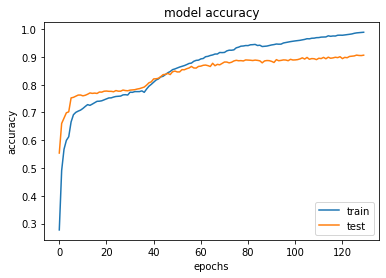

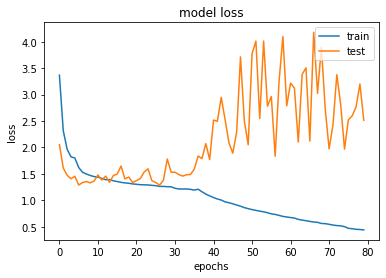

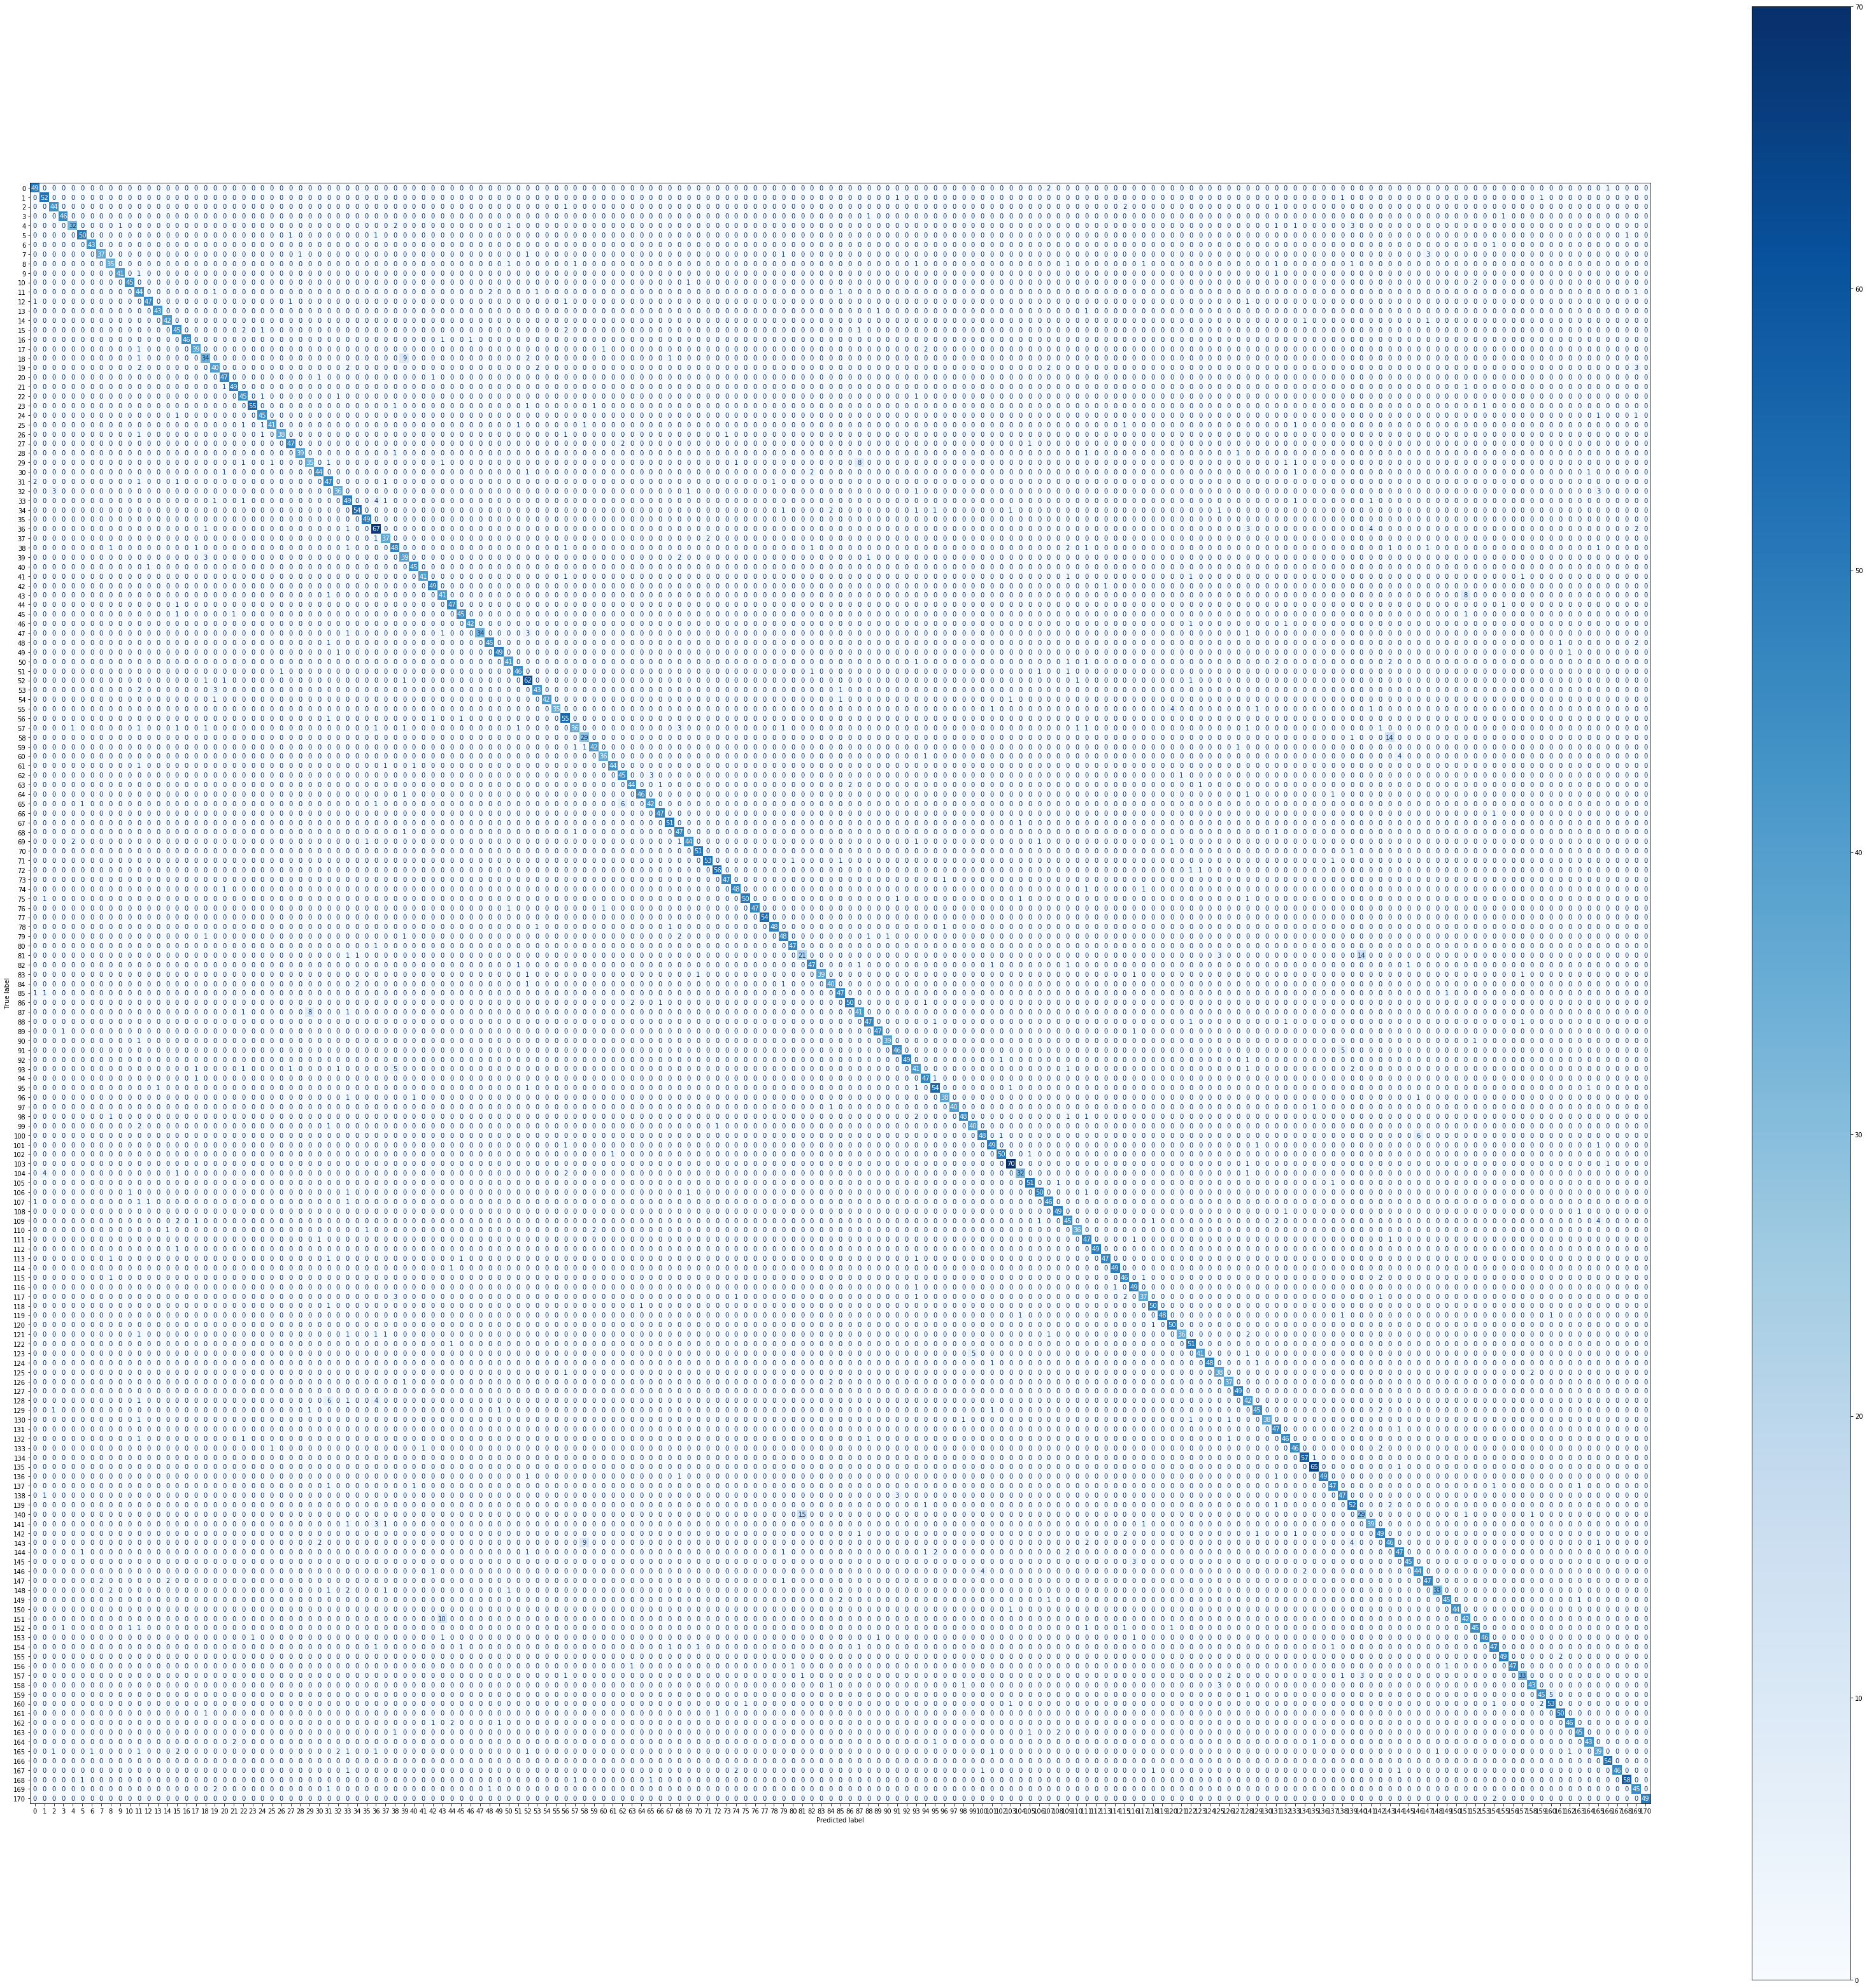

In [3]:
history3 = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs2,
    callbacks=[callback],
    validation_data=validation_generator,
    validation_steps=1)

# model.save_weights('first_try0.h5')

# summarize history for accuracy
plt.plot(history1.history['accuracy']+history2.history['accuracy']+history3.history['accuracy'])
plt.plot(history1.history['val_accuracy']+history2.history['val_accuracy']+history3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(history1.history['loss']+history2.history['loss'])
plt.plot(history1.history['val_loss']+history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

filenames = validation_generator.filenames

predict = model.predict(validation_generator)
y_pred = np.argmax(predict,axis=-1)

cm = confusion_matrix(validation_generator.classes,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm,
#                               display_labels=clf.classes_)

fig, ax = plt.subplots(figsize=(math.ceil(num_classes/3.0), math.ceil(num_classes/3.0)))
disp.plot(ax=ax, cmap=plt.cm.Blues)

Epoch 1/20
2152/2152 [==============================] - 308s 143ms/step - loss: 0.1628 - accuracy: 0.9885 - val_loss: 2.6321 - val_accuracy: 0.9061 - lr: 1.0000e-07
Epoch 2/20
2152/2152 [==============================] - 308s 143ms/step - loss: 0.1624 - accuracy: 0.9884 - val_loss: 2.5593 - val_accuracy: 0.9067 - lr: 1.0000e-07
Epoch 3/20
2152/2152 [==============================] - 309s 144ms/step - loss: 0.1582 - accuracy: 0.9898 - val_loss: 2.3795 - val_accuracy: 0.9063 - lr: 1.0000e-07
Epoch 4/20
2152/2152 [==============================] - 310s 144ms/step - loss: 0.1628 - accuracy: 0.9878 - val_loss: 2.1896 - val_accuracy: 0.9070 - lr: 1.0000e-07
Epoch 5/20
2152/2152 [==============================] - 309s 144ms/step - loss: 0.1598 - accuracy: 0.9893 - val_loss: 2.2920 - val_accuracy: 0.9066 - lr: 5.0000e-07
Epoch 6/20
2152/2152 [==============================] - 307s 143ms/step - loss: 0.1612 - accuracy: 0.9887 - val_loss: 2.4021 - val_accuracy: 0.9058 - lr: 9.0000e-07
Epoch 7/20

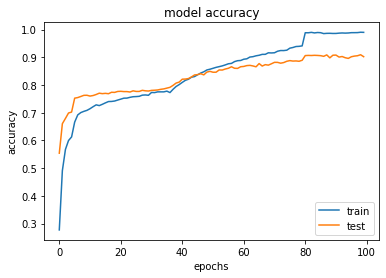

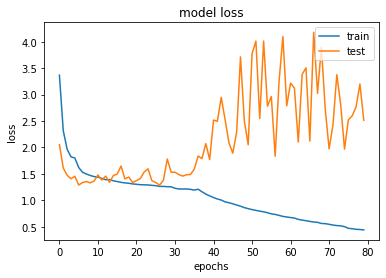

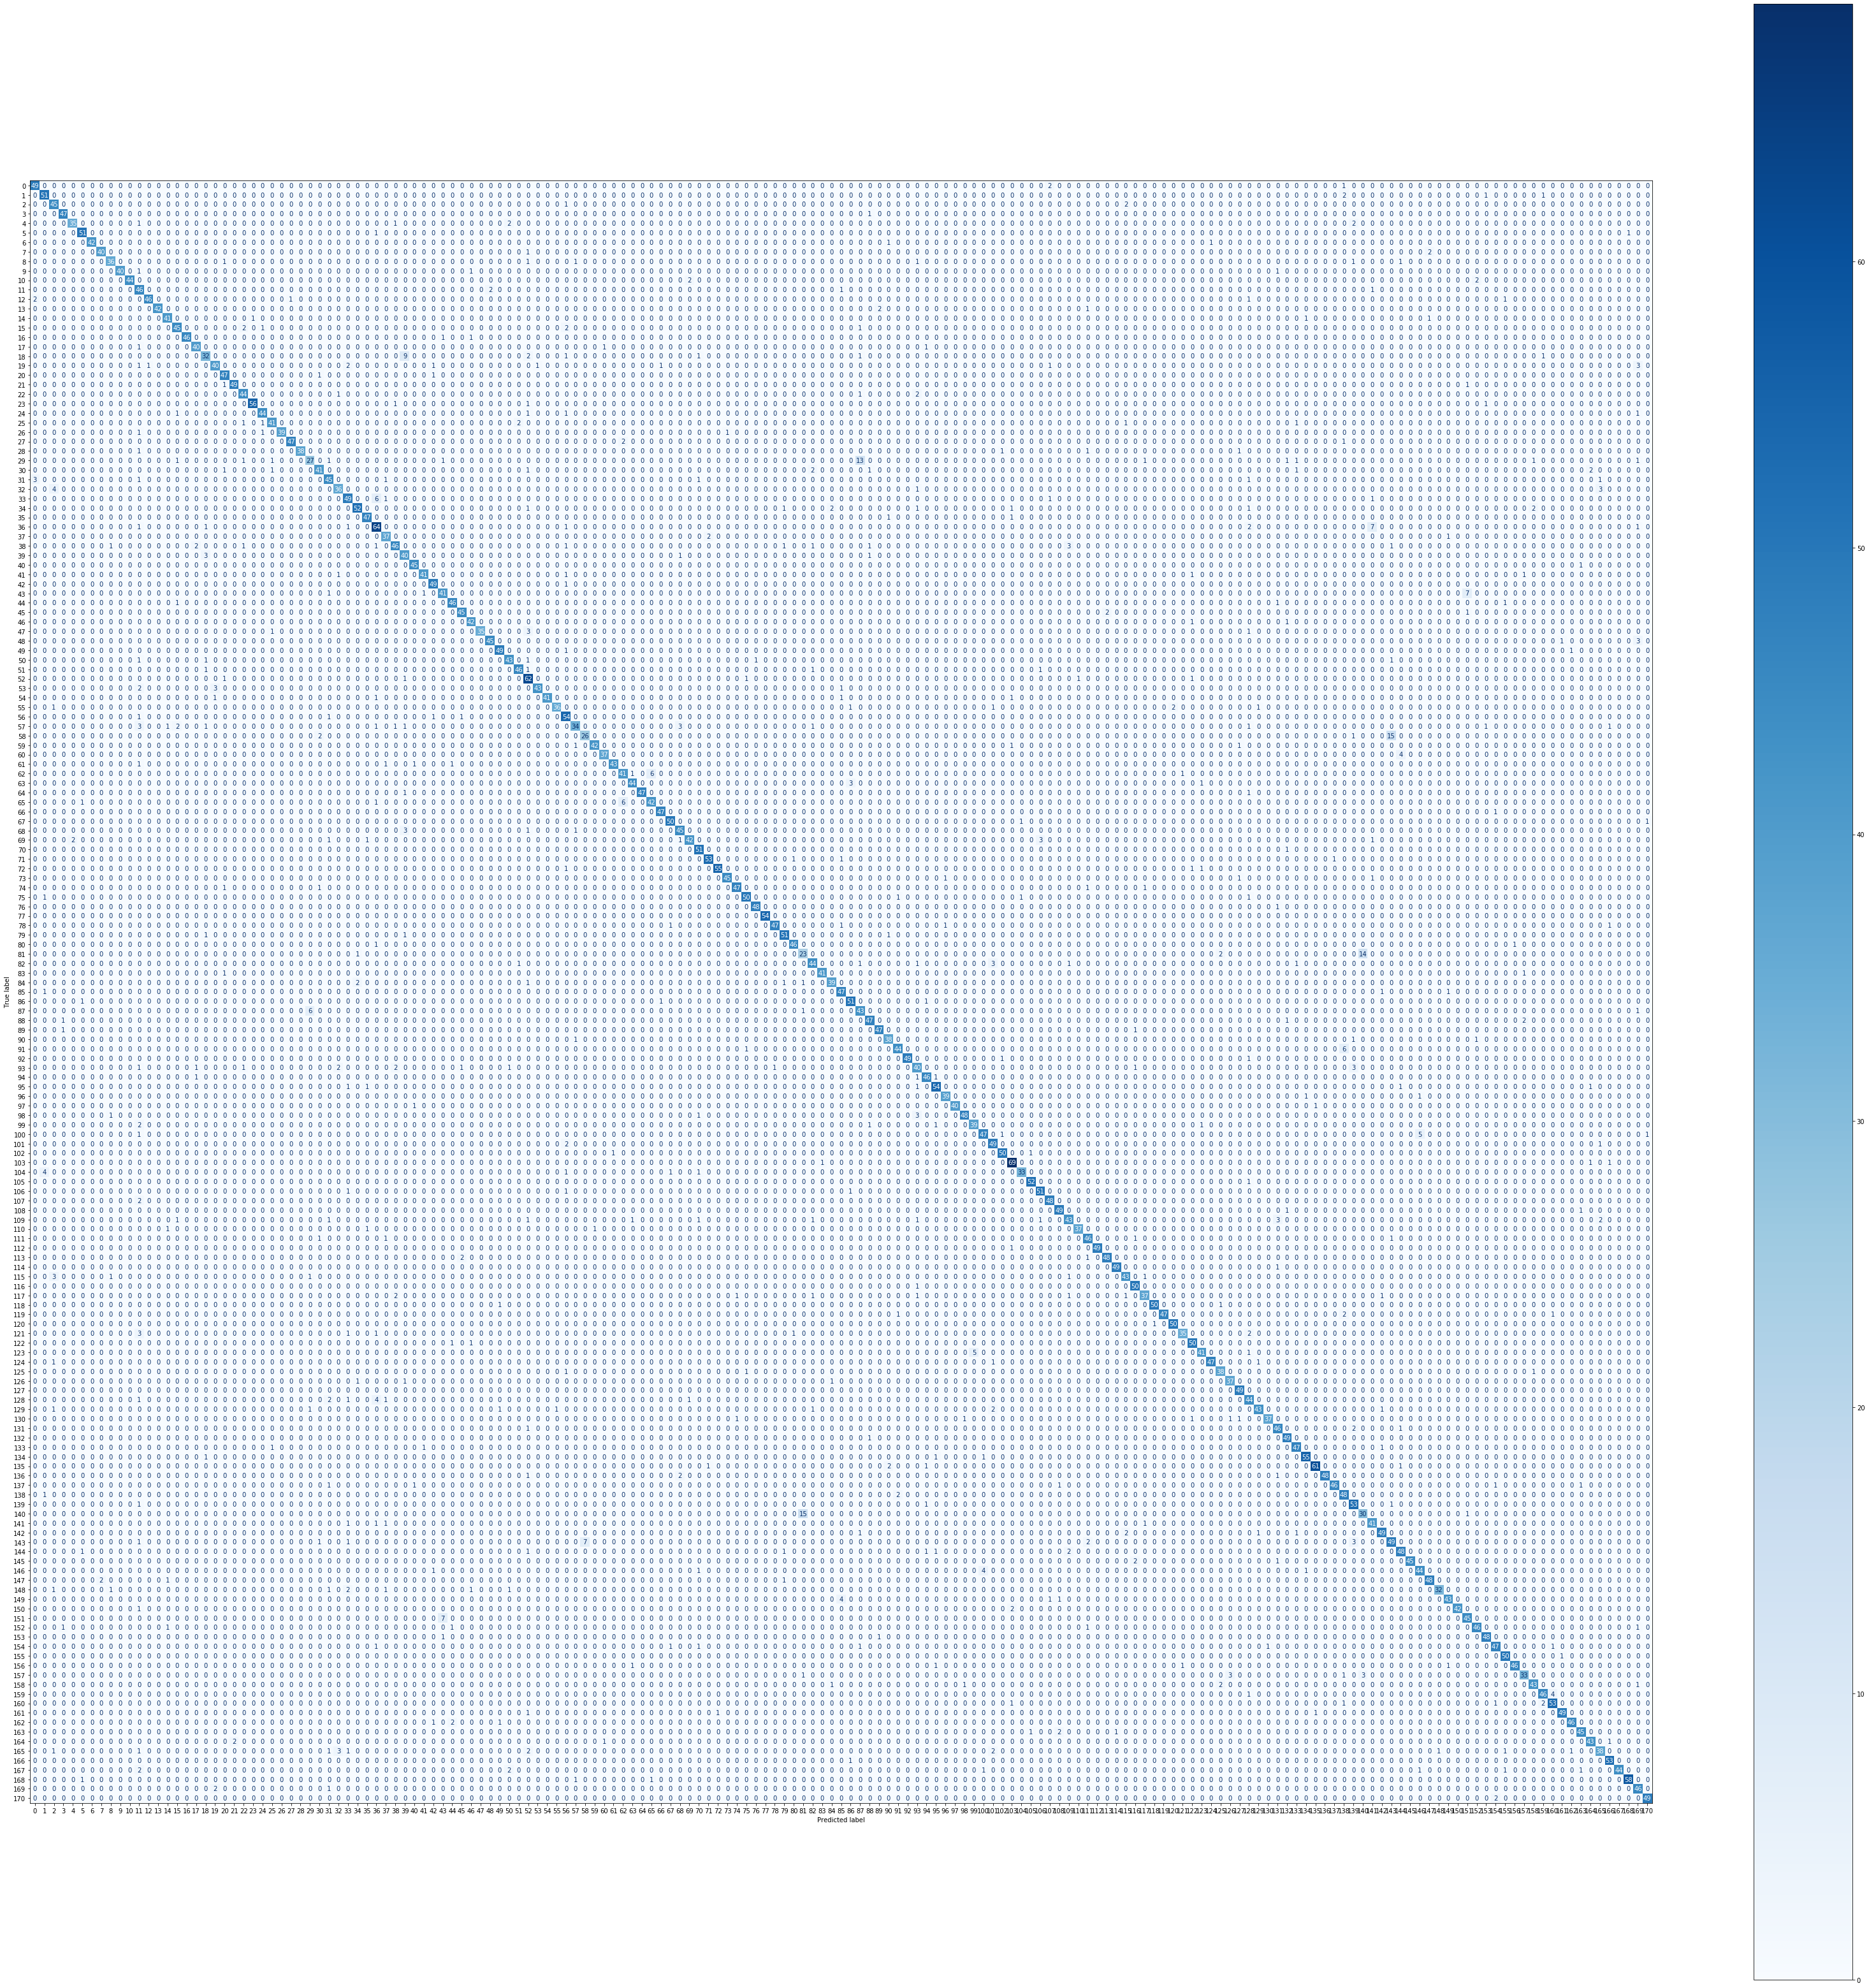

In [4]:
history3 = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=20,
    callbacks=[callback],
    validation_data=validation_generator,
    validation_steps=1)

# model.save_weights('first_try0.h5')

# summarize history for accuracy
plt.plot(history1.history['accuracy']+history2.history['accuracy']+history3.history['accuracy'])
plt.plot(history1.history['val_accuracy']+history2.history['val_accuracy']+history3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(history1.history['loss']+history2.history['loss'])
plt.plot(history1.history['val_loss']+history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

filenames = validation_generator.filenames

predict = model.predict(validation_generator)
y_pred = np.argmax(predict,axis=-1)

cm = confusion_matrix(validation_generator.classes,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm,
#                               display_labels=clf.classes_)

fig, ax = plt.subplots(figsize=(math.ceil(num_classes/3.0), math.ceil(num_classes/3.0)))
disp.plot(ax=ax, cmap=plt.cm.Blues)

In [5]:
print('precision_score: ', precision_score(validation_generator.classes,y_pred, average="macro"))
print('recall_score   : ', recall_score(validation_generator.classes,y_pred, average="macro"))
print('f1_score       : ', f1_score(validation_generator.classes,y_pred, average="macro"))
print('accuracy_score : ', accuracy_score(validation_generator.classes,y_pred, normalize=True))

print("\nBest accuracy  : ", max(max(history1.history['val_accuracy']), max(history2.history['val_accuracy'])))

precision_score:  0.9077028574940567
recall_score   :  0.9015356483131909
f1_score       :  0.9029184232235535
accuracy_score :  0.902112676056338

Best accuracy  :  0.8892018795013428
